# Starter Notebook - StatsSA

This notebook introduces the Zindi competition **Women in Big Data South Africa - Women-Headed Households in South Africa**. We'll take a quick look at the data, show how to create a model, estimate the score you'll get on Zindi, prepare your submission and get onto the leaderboard. I've also given some hints as to how to get a better score - once you have your first submission in, these might give you some ideas for what to try next.

# Loading the data
Make sure the CSV files provided by Zindi are in the same folder as this notebook. If it's running on Google Colab, you can use the 'files' tab on the left to upload them. We load the training data from Train.csv, and print out the variable descriptions here for easy reference. 

In [1]:
import pandas as pd
import numpy as np
import os, random, math, glob
from IPython.display import Image as IM
from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]
import seaborn as sns
from scipy.stats import boxcox
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('data/Train.csv')
df.head()

ward  total_households  total_individuals     target     dw_00  \
0  41601001: Ward 1        1674.45058         5888.20750  16.773757  0.933841   
1  41601002: Ward 2        1736.99230         6735.33812  21.496661  0.696940   
2  41601003: Ward 3        2403.57591         7273.04995  10.931425  0.810545   
3  41601004: Ward 4        1740.78737         5734.49046  23.119257  0.659914   
4  41601005: Ward 5        1730.51451         6657.23835  13.652252  0.950575   

      dw_01     dw_02     dw_03     dw_04     dw_05  ...     pw_03     pw_04  \
0  0.000846  0.005490  0.000676  0.000000  0.001372  ...  0.002848  0.007537   
1  0.001253  0.004402  0.000000  0.002301  0.001323  ...  0.014566  0.057127   
2  0.004517  0.008891  0.003986  0.007735  0.000956  ...  0.057560  0.010358   
3  0.000000  0.006129  0.000000  0.000813  0.037245  ...  0.000000  0.000669   
4  0.000655  0.001473  0.000598  0.006999  0.000818  ...  0.004859  0.001290   

      pw_05     pw_06  pw_07  pw_08  ADM4_PCODE        lat        lon  \
0  0.000000  0.012928      0      0   ZA4161001 -29.682270  24.734743   
1  0.019092  0.004131      0      0   ZA4161002 -29.119311  24.757737   
2  0.001421  0.040881      0      0   ZA4161003 -29.142276  25.094093   
3  0.000000  0.005011      0      0   ZA4161004 -29.372052  24.942867   
4  0.000673  0.017629      0      0   ZA4161005 -29.409381  25.290165   

         NL  
0  0.292039  
1  3.207775  
2  0.000000  
3  2.038778  
4  0.000000  

[5 rows x 63 columns]

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 63 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ward               2822 non-null   object 
 1   total_households   2822 non-null   float64
 2   total_individuals  2822 non-null   float64
 3   target             2822 non-null   float64
 4   dw_00              2822 non-null   float64
 5   dw_01              2822 non-null   float64
 6   dw_02              2822 non-null   float64
 7   dw_03              2822 non-null   float64
 8   dw_04              2822 non-null   float64
 9   dw_05              2822 non-null   float64
 10  dw_06              2822 non-null   float64
 11  dw_07              2822 non-null   float64
 12  dw_08              2822 non-null   float64
 13  dw_09              2822 non-null   float64
 14  dw_10              2822 non-null   float64
 15  dw_11              2822 non-null   float64
 16  dw_12              2822 

In [4]:
df.isnull().sum().sort_values(ascending=False)

ward      0
pg_03     0
lan_05    0
lan_06    0
lan_07    0
         ..
car_01    0
lln_00    0
lln_01    0
lan_00    0
NL        0
Length: 63, dtype: int64

In [5]:
df.describe()

total_households  total_individuals       target        dw_00  \
count       2822.000000        2822.000000  2822.000000  2822.000000   
mean        3665.281214       12869.130053    24.507554     0.712196   
std         3266.364522        9696.690518    10.294387     0.214035   
min            1.000000         402.000000     0.000000     0.000000   
25%         1778.858235        7071.205695    16.751556     0.594212   
50%         2398.249935        9366.989680    24.156670     0.766841   
75%         3987.080563       14241.233015    32.226553     0.881708   
max        39684.942130       91716.746370    55.528423     0.994962   

             dw_01        dw_02        dw_03        dw_04        dw_05  \
count  2822.000000  2822.000000  2822.000000  2822.000000  2822.000000   
mean      0.092616     0.032043     0.006057     0.008665     0.006289   
std       0.182852     0.080253     0.019374     0.030697     0.024606   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.002895     0.002407     0.000000     0.000000     0.000000   
50%       0.010425     0.005762     0.000807     0.000607     0.000865   
75%       0.068209     0.027913     0.002538     0.002225     0.003027   
max       0.931490     0.951806     0.264239     0.392085     0.435912   

             dw_06  ...        pw_02        pw_03        pw_04        pw_05  \
count  2822.000000  ...  2822.000000  2822.000000  2822.000000  2822.000000   
mean      0.022375  ...     0.127555     0.041589     0.019655     0.011008   
std       0.037127  ...     0.156400     0.057331     0.032926     0.023672   
min       0.000000  ...     0.000000     0.000000     0.000000     0.000000   
25%       0.002716  ...     0.008673     0.002099     0.000715     0.000159   
50%       0.008639  ...     0.069065     0.016496     0.005164     0.001459   
75%       0.025218  ...     0.183384     0.058626     0.025055     0.009432   
max       0.412936  ...     1.000000     0.327393     0.306787     0.228261   

             pw_06   pw_07   pw_08          lat          lon           NL  
count  2822.000000  2822.0  2822.0  2822.000000  2822.000000  2822.000000  
mean      0.110818     0.0     0.0   -26.880740    28.666515    17.437560  
std       0.185401     0.0     0.0     2.021279     2.373809    18.958621  
min       0.000000     0.0     0.0   -32.490089    16.760022     0.000000  
25%       0.005217     0.0     0.0   -28.569019    27.707932     3.033397  
50%       0.025165     0.0     0.0   -26.549866    28.959679     9.205572  
75%       0.116638     0.0     0.0   -25.572130    30.441505    26.890531  
max       0.961523     0.0     0.0   -22.331267    32.858249    63.000000  

[8 rows x 61 columns]

In [6]:
df.nunique().sort_values().head(10)

dw_13        1
lan_13       1
dw_12        1
pw_08        1
pw_07        1
lan_14    1459
dw_10     1695
dw_04     1799
dw_05     1952
dw_03     2094
dtype: int64

In [7]:
df[['dw_13', 'lan_13', 'dw_12', 'pw_08', 'pw_07']]

dw_13  lan_13  dw_12  pw_08  pw_07
0         0       0      0      0      0
1         0       0      0      0      0
2         0       0      0      0      0
3         0       0      0      0      0
4         0       0      0      0      0
...     ...     ...    ...    ...    ...
2817      0       0      0      0      0
2818      0       0      0      0      0
2819      0       0      0      0      0
2820      0       0      0      0      0
2821      0       0      0      0      0

[2822 rows x 5 columns]

['dw_13', 'lan_13', 'dw_12', 'pw_08', 'pw_07'] have only 0 in them --> we could drop these features

In [8]:
# drop features with only 0 in them
df = df.drop(['ward', 'dw_13', 'lan_13', 'dw_12', 'pw_08', 'pw_07', 'ADM4_PCODE'], axis=1)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2822 entries, 0 to 2821
Data columns (total 56 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_households   2822 non-null   float64
 1   total_individuals  2822 non-null   float64
 2   target             2822 non-null   float64
 3   dw_00              2822 non-null   float64
 4   dw_01              2822 non-null   float64
 5   dw_02              2822 non-null   float64
 6   dw_03              2822 non-null   float64
 7   dw_04              2822 non-null   float64
 8   dw_05              2822 non-null   float64
 9   dw_06              2822 non-null   float64
 10  dw_07              2822 non-null   float64
 11  dw_08              2822 non-null   float64
 12  dw_09              2822 non-null   float64
 13  dw_10              2822 non-null   float64
 14  dw_11              2822 non-null   float64
 15  psa_00             2822 non-null   float64
 16  psa_01             2822 

In [10]:
df.shape

(2822, 56)

In [11]:
var_desc = pd.read_csv('data/variable_descriptions.csv')
pd.set_option('display.max_colwidth', 200) # So that we can see the full descriptions
var_desc

Column  \
0        dw_00   
1        dw_01   
2        dw_02   
3        dw_03   
4        dw_04   
5        dw_05   
6        dw_06   
7        dw_07   
8        dw_08   
9        dw_09   
10       dw_10   
11       dw_11   
12       dw_12   
13       dw_13   
14      psa_00   
15      psa_01   
16      psa_02   
17      psa_03   
18      psa_04   
19      stv_00   
20      stv_01   
21      car_00   
22      car_01   
23      lln_00   
24      lln_01   
25      lan_00   
26      lan_01   
27      lan_02   
28      lan_03   
29      lan_04   
30      lan_05   
31      lan_06   
32      lan_07   
33      lan_08   
34      lan_09   
35      lan_10   
36      lan_11   
37      lan_12   
38      lan_13   
39      lan_14   
40       pg_00   
41       pg_01   
42       pg_02   
43       pg_03   
44       pg_04   
45      lgt_00   
46       pw_00   
47       pw_01   
48       pw_02   
49       pw_03   
50       pw_04   
51       pw_05   
52       pw_06   
53       pw_07   
54       pw_08   
55  ADM4_PCODE   
56         lat   
57         lon   
58          NL   
59      target   

                                                                                                                                    Description  \
0                             Percentage of dwellings of type: House or brick/concrete block structure on a separate stand or yard or on a farm   
1                                             Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials   
2                                                                        Percentage of dwellings of type: Flat or apartment in a block of flats   
3                                                                                     Percentage of dwellings of type: Cluster house in complex   
4                                                                 Percentage of dwellings of type: Townhouse (semi-detached house in a complex)   
5                                                                                          Percentage of dwellings of type: Semi-detached house   
6                                                                                  Percentage of dwellings of type: House/flat/room in backyard   
7                                                                                     Percentage of dwellings of type: Informal dwelling (shack   
8                                                                                     Percentage of dwellings of type: Informal dwelling (shack   
9                                  Percentage of dwellings of type: Room/flatlet on a property or larger dwelling/servants quarters/granny flat   
10                                                                                                Percentage of dwellings of type: Caravan/tent   
11                                                                                                       Percentage of dwellings of type: Other   
12                                                                                                 Percentage of dwellings of type: Unspecified   
13                                                                                              Percentage of dwellings of type: Not applicable   
14                                                                                        Percentage listing present school attendance as:  Yes   
15                                                                                         Percentage listing present school attendance as:  No   
16                                                                                Percentage listing present school attendance as:  Do not know   
17                                                                                Percentage listing present school attendance as:  Unspecified   
18                                                                             Percentage listing present school att

# Quick EDA
Before we dive into modelling, let's take a quick look at the data and see what we have to work with. 

In [12]:
df[['pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06']].head(10)

pw_00     pw_01     pw_02     pw_03     pw_04     pw_05     pw_06
0  0.742692  0.214027  0.019968  0.002848  0.007537  0.000000  0.012928
1  0.309294  0.576844  0.018946  0.014566  0.057127  0.019092  0.004131
2  0.323393  0.483376  0.083010  0.057560  0.010358  0.001421  0.040881
3  0.677437  0.314194  0.002689  0.000000  0.000669  0.000000  0.005011
4  0.771106  0.194743  0.009699  0.004859  0.001290  0.000673  0.017629
5  0.271839  0.614012  0.027496  0.020771  0.002275  0.024184  0.039423
6  0.468464  0.471754  0.032712  0.003827  0.000509  0.002542  0.020192
7  0.438984  0.504604  0.022997  0.006364  0.001279  0.000526  0.025246
8  0.445067  0.530498  0.008259  0.006109  0.001276  0.000000  0.008791
9  0.566512  0.426079  0.002110  0.002644  0.000000  0.000583  0.002073

## Looking at the target variable
The purpose of this competition is to predict the percentage of households in a ward that are woman-headed and have an annual household income of <R19,600. To put that in context, that's less than 250USD per month. 

Text(0.5, 0, 'Percentage of households that are w-headed and have income under R19.6k/month')

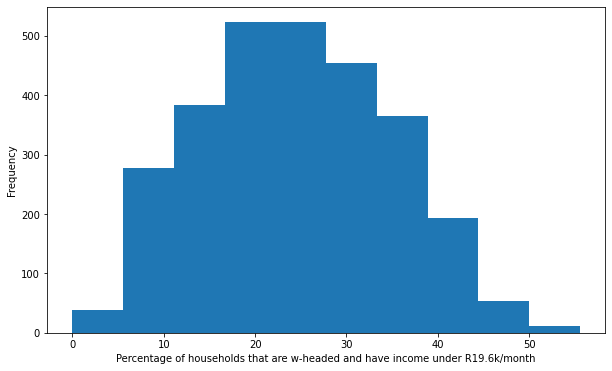

In [13]:
# Plot the distribution
ax = df['target'].plot(kind='hist')
plt.xlabel('Percentage of households that are w-headed and have income under R19.6k/month')

# Looking at a few interesting correlations

In [16]:
# Strong +ve correlations
df.corr()['target'].sort_values().head(10)

pw_00    -0.754536
psa_01   -0.707506
car_00   -0.702831
stv_00   -0.664181
lln_00   -0.637835
pg_03    -0.583908
NL       -0.514398
lan_00   -0.507942
lan_01   -0.438704
dw_04    -0.385533
Name: target, dtype: float64

In [17]:
pos_corr = df.corr()['target'].sort_values(ascending=False).iloc[1:6] # positive correletion value > 0.5
neg_corr = df.corr()['target'].sort_values().head(7) # negative correletion value > -0.5


In [18]:
corr_all = pd.concat([pos_corr, neg_corr])

sign = pd.DataFrame(np.where(corr_all > 0, 1, -1), index=corr_all.index, columns=['sign'])

corr_all = pd.concat([abs(corr_all), sign], axis=1)

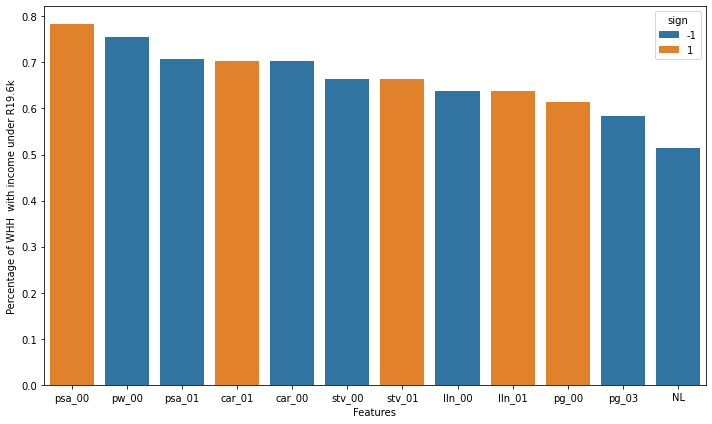

In [19]:
sns.barplot(x=corr_all.index,y=corr_all.target, hue=corr_all.sign, order=corr_all.target.sort_values(ascending=False).index, dodge=False) 
plt.xlabel('Features')
plt.ylabel('Percentage of WHH  with income under R19.6k')
plt.tight_layout();

## Clustering

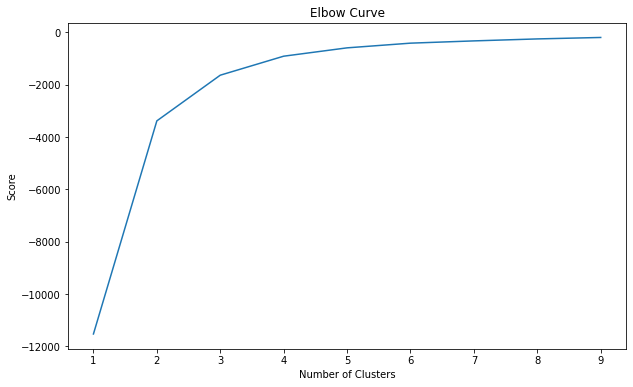

In [20]:
K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]
Y_axis = df[['lat']]
X_axis = df[['lon']]
score = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]
# Visualize
plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 3, init ='k-means++')
kmeans.fit(df[['lat', 'lon']]) # Compute k-means clustering.
df['cluster_label'] = kmeans.fit_predict(df[['lat', 'lon']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(df[['lat', 'lon']])

<AxesSubplot:xlabel='lat', ylabel='lon'>

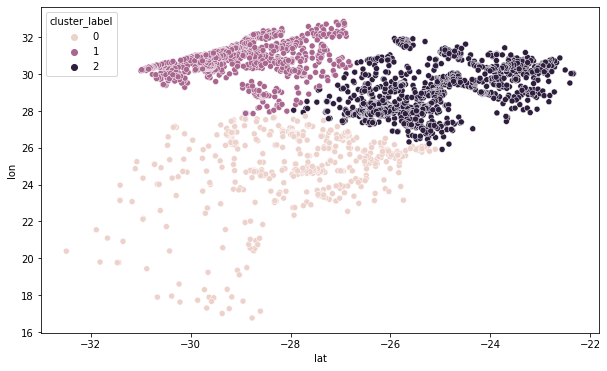

In [22]:
sns.scatterplot(data=df, x='lat', y='lon', hue='cluster_label')

In [23]:
df_groupby = df.groupby(by='cluster_label').mean().reset_index()
df_groupby

cluster_label  total_households  total_individuals     target     dw_00  \
0              0       2285.172030        8066.411859  21.757704  0.786800   
1              1       3125.423048       12370.811779  28.431772  0.586777   
2              2       4508.069217       15022.911035  23.364846  0.753896   

      dw_01     dw_02     dw_03     dw_04     dw_05  ...     pw_00     pw_01  \
0  0.025030  0.017083  0.002103  0.005186  0.009486  ...  0.390881  0.370473   
1  0.257204  0.048114  0.006733  0.005265  0.004714  ...  0.294118  0.271466   
2  0.026073  0.028805  0.007217  0.011941  0.005931  ...  0.384540  0.346638   

      pw_02     pw_03     pw_04     pw_05     pw_06        lat        lon  \
0  0.130163  0.041623  0.015780  0.007893  0.043186 -27.955095  25.068685   
1  0.152945  0.047333  0.021779  0.013392  0.198966 -28.929056  30.681654   
2  0.112208  0.038334  0.019967  0.010877  0.087435 -25.305781  28.931916   

          NL  
0  10.065975  
1  12.437206  
2  23.133883  

[3 rows x 57 columns]

In [ ]:
#df[['lat', 'lon', 'cluster_label', 'target']].to_csv('df_to_keplar.csv')

Text(0, 0.5, 'Mean percentage of WHH  with income under R19.6k')

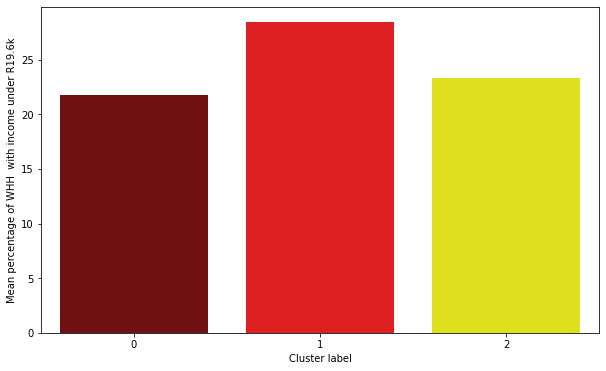

In [24]:
clrs = ['maroon' if (x == 0) else 'red' if (x == 1)  else 'yellow' for x in df_groupby['cluster_label'] ]
sns.barplot(data=df_groupby, x='cluster_label', y='target', palette=clrs)
plt.xlabel('Cluster label')
plt.ylabel('Mean percentage of WHH  with income under R19.6k')

## Feature Importance Plot

In [26]:
df_feature = pd.read_csv('data/featureweights.csv') # featureweights.csv provied by Corrina
df_feature.head()

target feature     weight
0      y  psa_00  64.396498
1      y  <BIAS>  31.743417
2      y  lln_00  13.267810
3      y   pg_03   6.597892
4      y  stv_00   5.147022

In [27]:
df_feature.drop([1,5,6], inplace=True)
df_feature['weight'] = abs(df_feature['weight'])
weight_order = df_feature.sort_values(by='weight', ascending=False).feature

Text(0, 0.5, 'Feature')

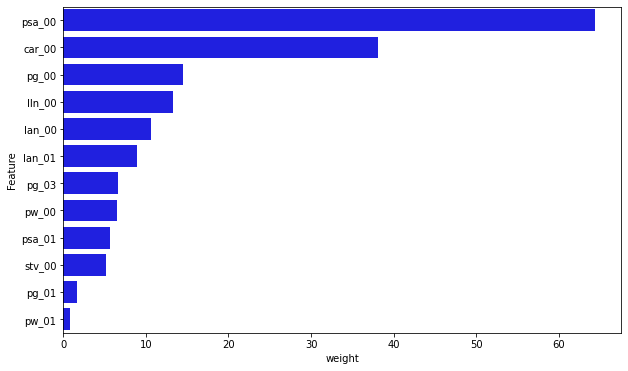

In [28]:
sns.barplot(data=df_feature, y='feature', x='weight', order=weight_order, color='b')
plt.ylabel('Feature')


In [ ]:
#df_kapler = df[['lat', 'lon', 'target', 'cluster_label', 'pw_00', 'psa_00', 'car_00', 'pg_03', 'NL', 'lan_00', 'pg_00']]
#df_kapler.to_csv('data_kapler.csv')

## Heatmap

In [ ]:
# negatively correlated features (- 0.5 threshold)
list1 = list((df.corr()['target'].sort_values().head(8)).index)
# positively correlated features (+ 0.5 threshold)
list2 = list((df.corr()['target'].sort_values(ascending=False).iloc[1:6]).index)
# list2 = list((df.corr()['target'].sort_values(ascending=False).head(6)).index)
# combine both lists
corr_feature_list = list1 + list2
corr_feature_list

['pw_00',
 'psa_01',
 'car_00',
 'stv_00',
 'lln_00',
 'pg_03',
 'NL',
 'lan_00',
 'psa_00',
 'car_01',
 'stv_01',
 'lln_01',
 'pg_00']

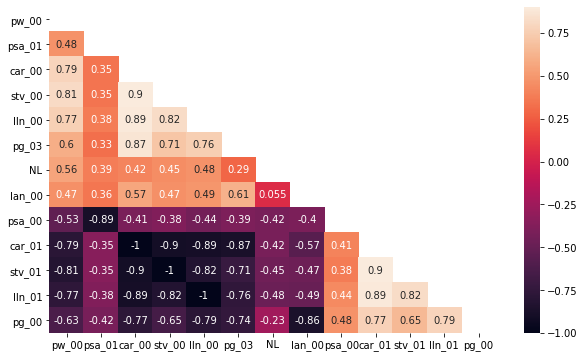

In [ ]:
corr = df[corr_feature_list].corr()
matrix = np.triu(corr)
sns.heatmap(corr, annot=True, mask=matrix);

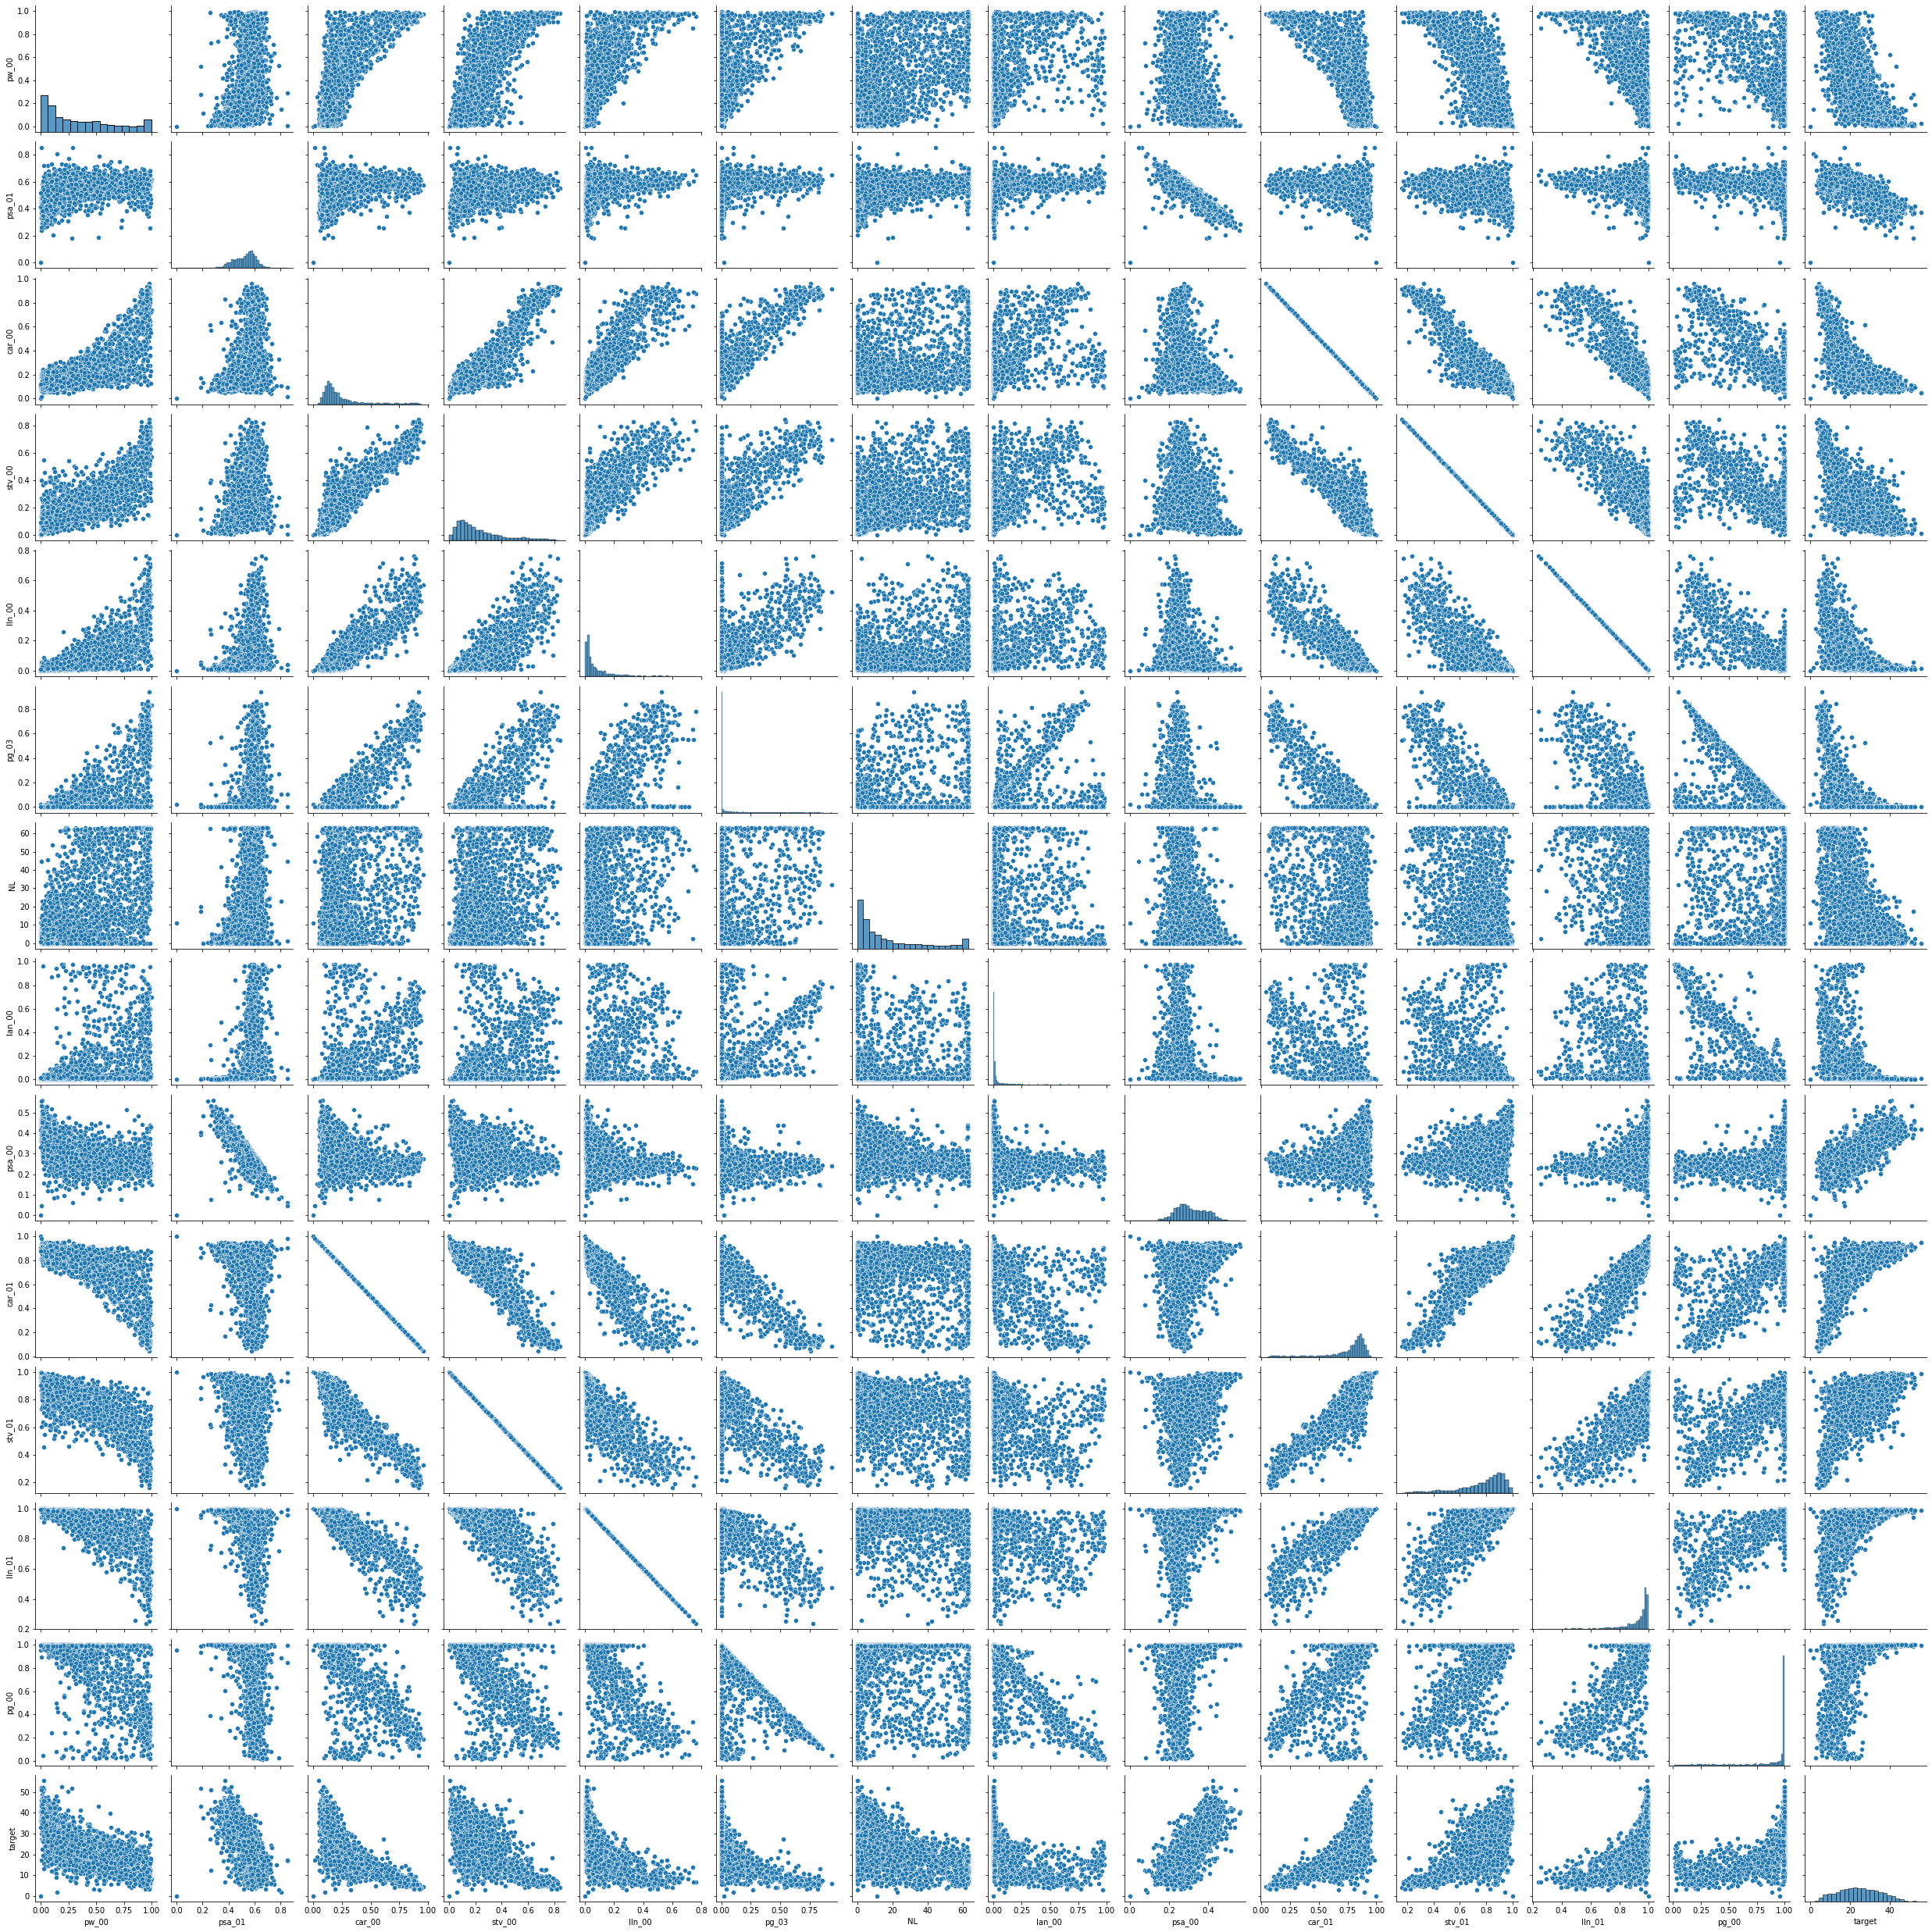

In [ ]:
corr_feature_list = corr_feature_list + ['target']
sns.pairplot(data=df[corr_feature_list]);

There are some high correlations here. Let's pick a few and investigate.

In [ ]:
# pw_00: running water in the home. Places where almost everyone has piped water tend to be more affluent.
#df.plot(x='pw_00', y='target', kind='scatter', alpha=0.3)

In [ ]:
# Nightlights (NL)
#df.plot(x='NL', y='target', kind='scatter', alpha=0.3)

In [ ]:
# dw_01: Percentage of dwellings of type: Traditional dwelling/hut/structure made of traditional materials
# Places where many of the buildings are 'traditional' tend to have more households 
# in the target category. 
#df.plot(x='dw_01', y='target', kind='scatter', alpha=0.3)

Notice that for the dwelling type example above, the left hand side of the graph is chaotic. Fitting a straight line would tell part of the story, but to fully capture the trend we'd have to look at this data in conjunction with info on all the other dwelling types, and think about how trends might be different in rural vs urban areas. 

### Tip - Take a look at more of these variables and explore their relationships further. This will give you some extra insight that may come in handy for feature engineering. It's also an interesting exercise on it's own - this is data about South Africa, and South African people. ...

In [ ]:
# households with a car
#df.plot(x='car_00', y='target', kind='scatter', alpha=0.3)


In [ ]:
corr_feature_list

['pw_00',
 'psa_01',
 'car_00',
 'stv_00',
 'lln_00',
 'pg_03',
 'NL',
 'lan_00',
 'psa_00',
 'car_01',
 'stv_01',
 'lln_01',
 'pg_00',
 'target']

In [ ]:
# reduced features:
#reduced_feature_list = ['pw_00', 'psa_01', 'car_00', 'pg_03', 'NL', 'lan_00', 'psa_00', 'pg_00', 'target'] %ravi : I have also removed 'psa_00' as its simply opposit of ''psa_00
reduced_feature_list = ['pw_00', 'psa_00', 'car_00', 'pg_03', 'NL', 'lan_00', 'pg_00', 'target']

df_reduced = df[reduced_feature_list]

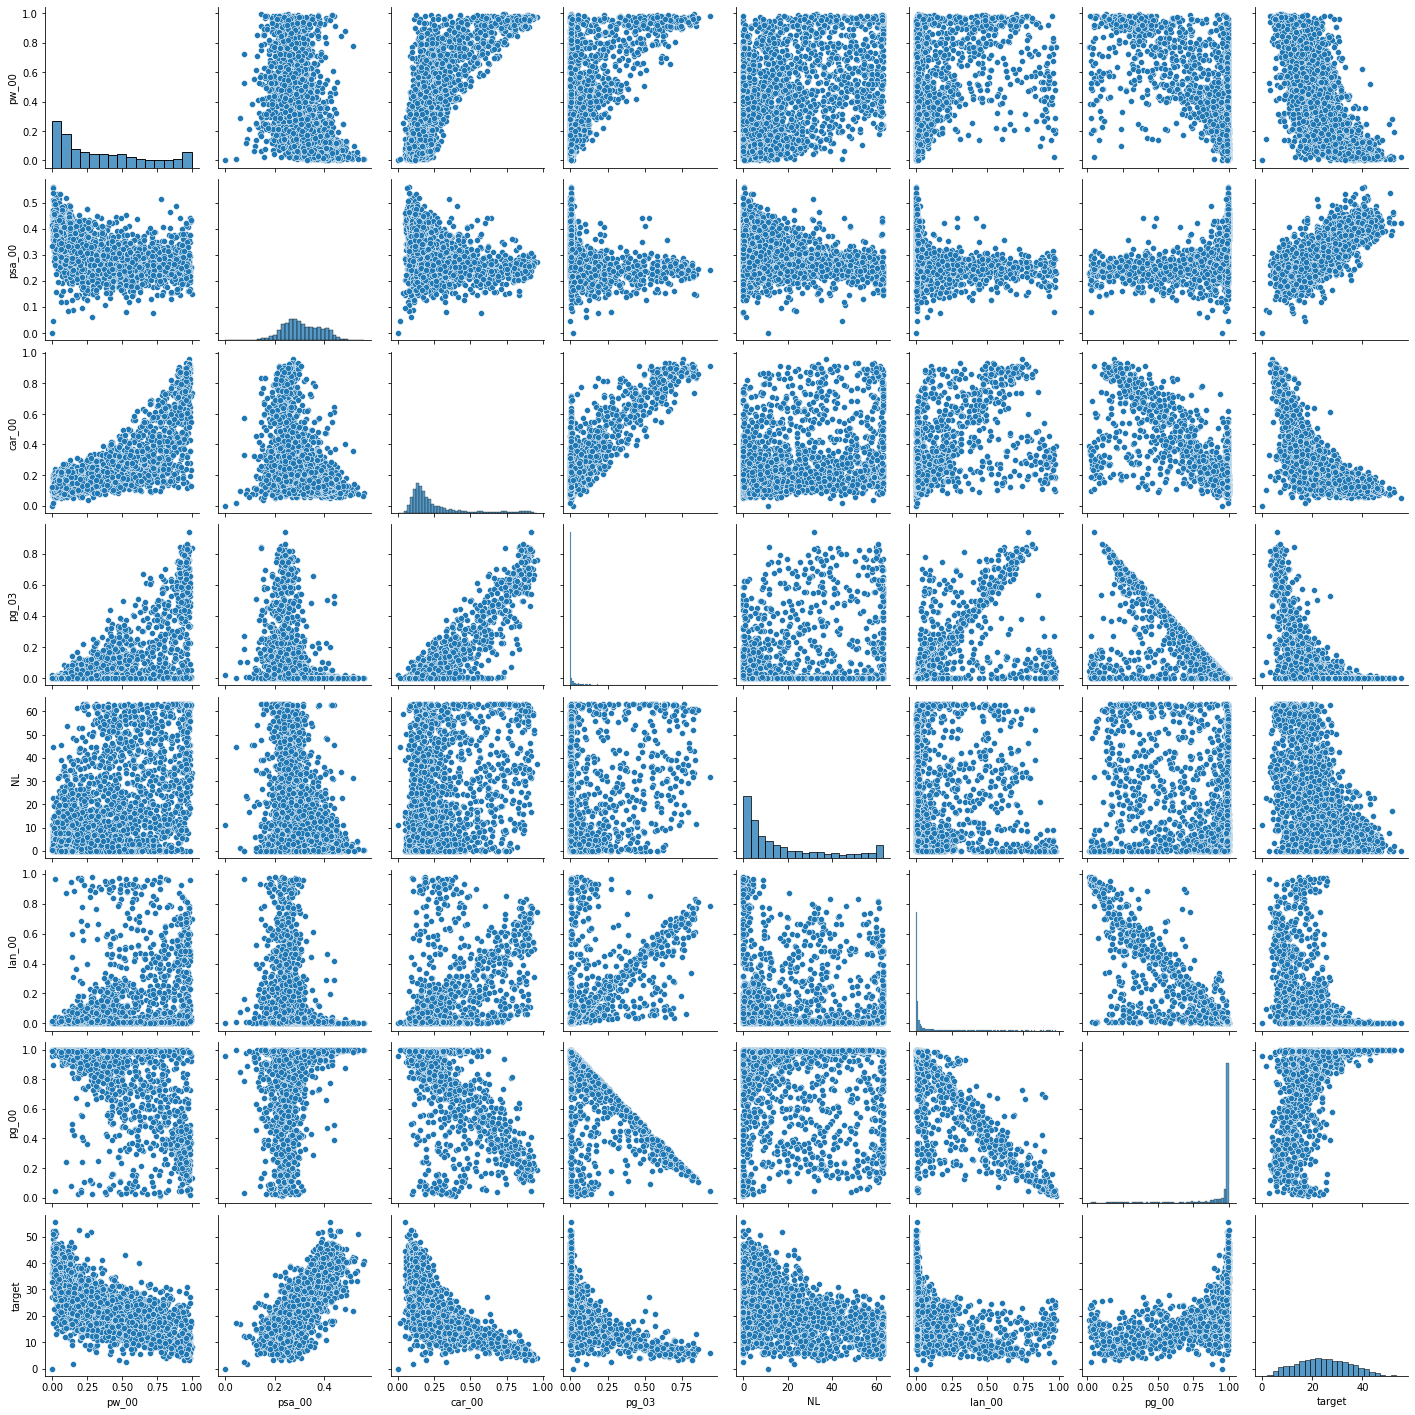

In [ ]:
sns.pairplot(df_reduced);

## Transformation

In [ ]:
def convert_zeros(x):
    '''
    function to convert zeros to a postive number 
    so that it can be transformed with the boxcox'''
    if x == 0.0:
        return 0.0000001
    else :
        return x
    


In [ ]:
print (df['pw_00'].isin([0]).sum())
print(df['pw_00'].apply(convert_zeros).isin([0]).sum())

1
0


/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_35596/857801595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[col] = df_reduced[col].apply(convert_zeros)
/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_35596/857801595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[col] = df_reduced[col].apply(convert_zeros)
/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_35596/857801595.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

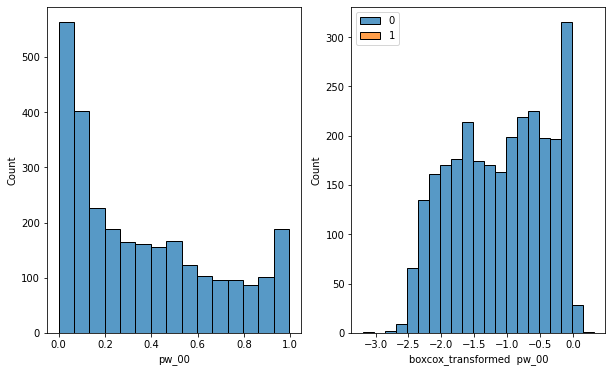

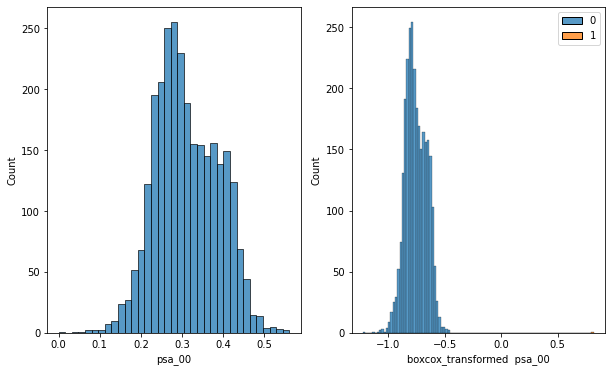

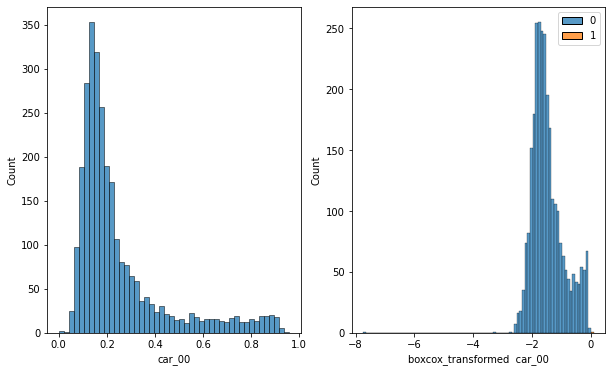

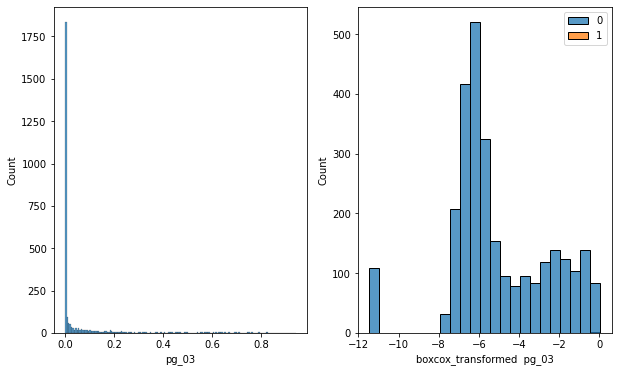

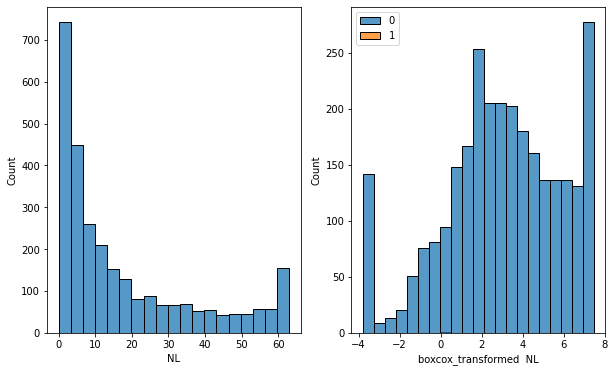

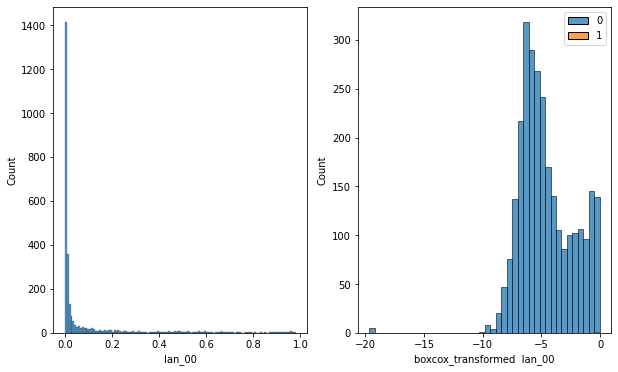

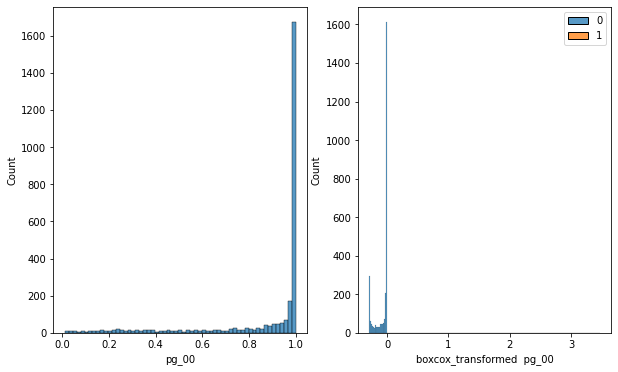

In [ ]:
for col in reduced_feature_list:
    if col != 'target':
        fig, axes = plt.subplots(1,2)
        df_reduced[col] = df_reduced[col].apply(convert_zeros)
        sns.histplot(df_reduced[col], ax=axes[0])
        plt.xlabel(col)
        sns.histplot(boxcox(df_reduced[col]), ax=axes[1])
        plt.xlabel('boxcox_transformed  ' + col)

On applying boxcox transformation, distributions of  features like 'pw_00', 'pg_03', 'NL' and 'lan_00' are shifted toward normal distributions, wheras for other features it didn't improve much  

In [ ]:
for col in reduced_feature_list:
    if col != 'target' and  col != 'psa_00' and col != 'car_00' and 'pg_00':
        df_reduced[col] = boxcox(df_reduced[col])[0].reshape(-1,1);

/var/folders/4q/jchndf6x7rv99dbr5nzt756h0000gn/T/ipykernel_35596/813663105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced[col] = boxcox(df_reduced[col])[0].reshape(-1,1);


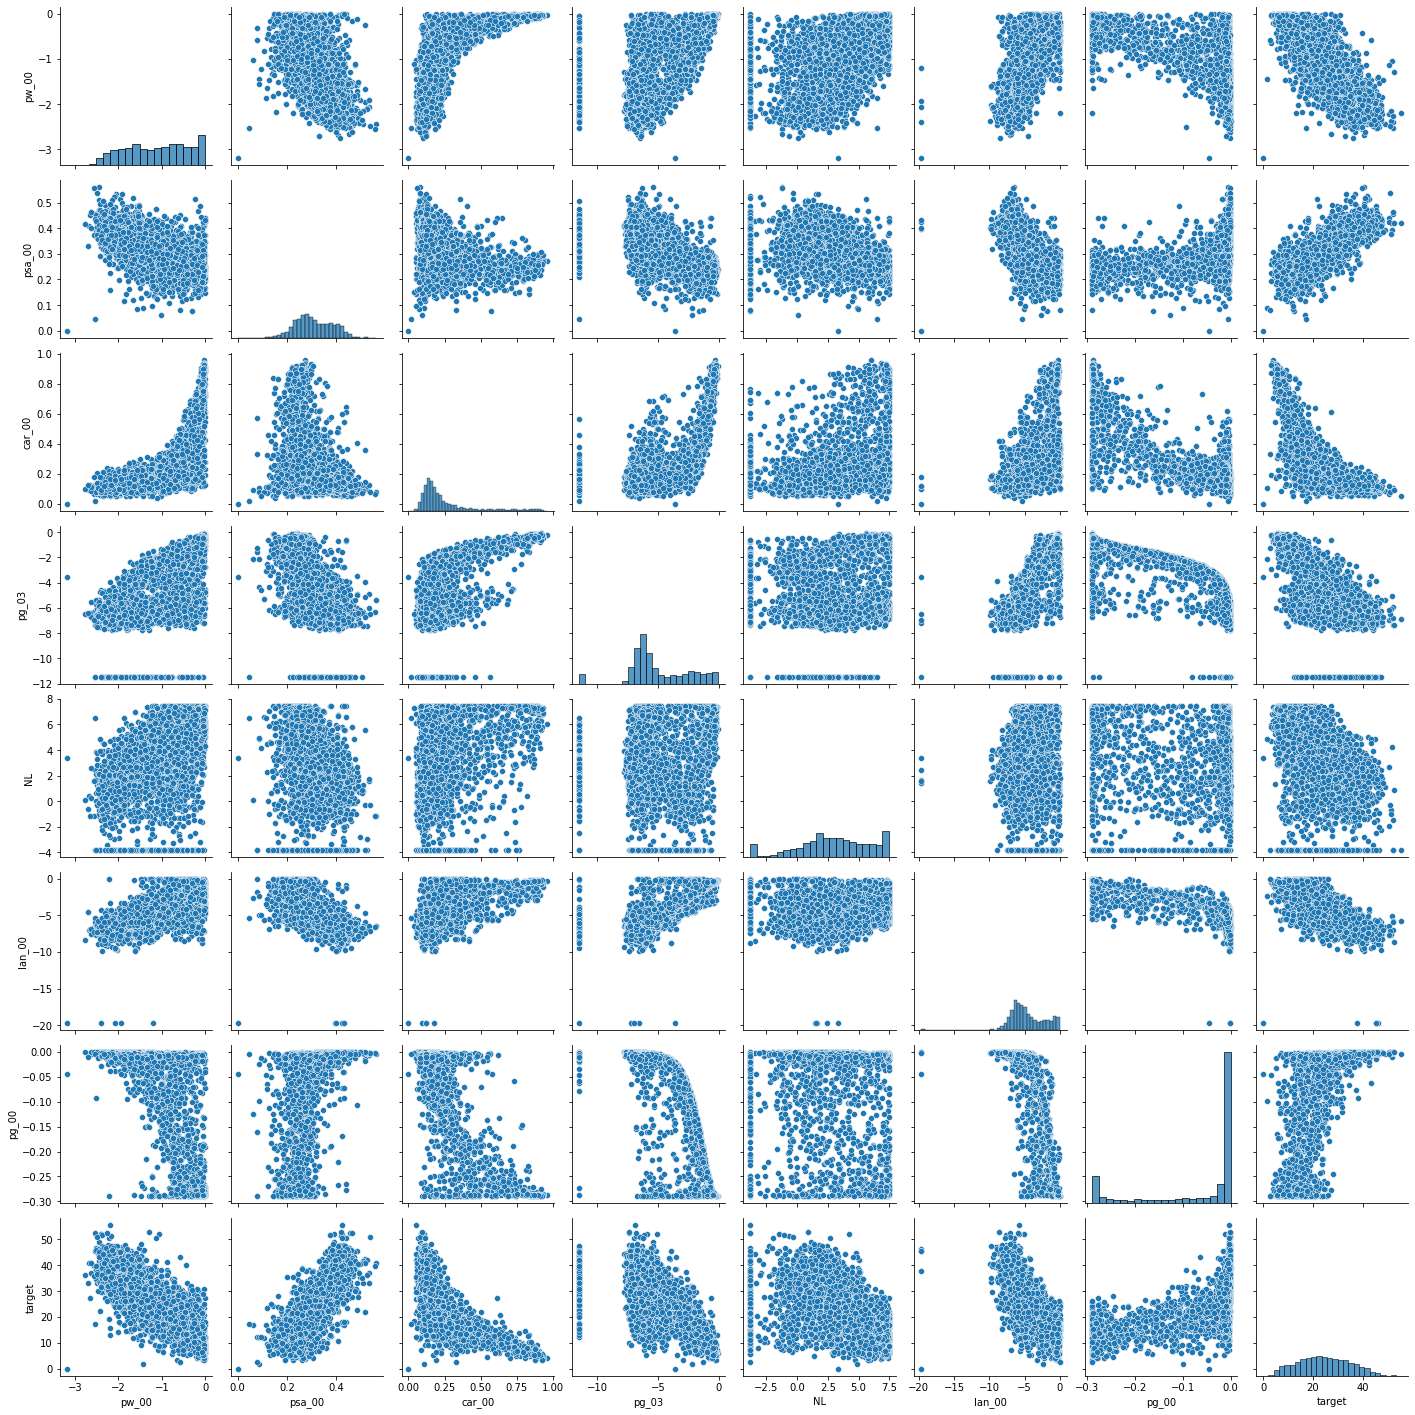

In [ ]:
sns.pairplot(df_reduced);

<AxesSubplot:xlabel='lat', ylabel='lon'>

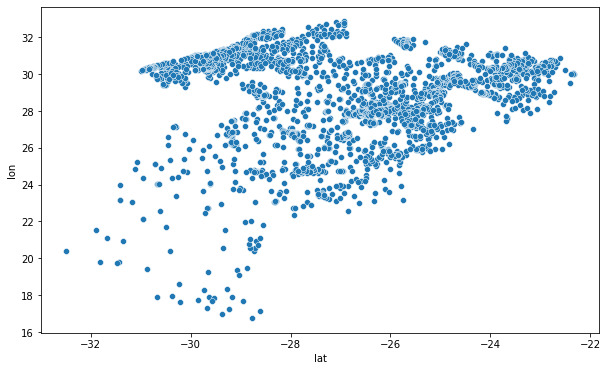

In [ ]:
sns.scatterplot(data=df, x='lat', y='lon')

# Modelling
At this stage, most tutorials/notebooks would go into feature engineering. But I like to do a quick model FIRST, to see how tough the problem is and give us a baseline to compare to. So, in this section we'll try a simple linear model and then a more complicated Random Forest regressor, and set up a means to score our models locally (so that we don't have to keep submitting on Zindi).

In [ ]:
# Define our input columns.
in_cols = df.drop('ADM4_PCODE', axis=1).columns[4:]
in_cols

Index(['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02',
       'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00',
       'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05',
       'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12',
       'lan_14', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
       'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat',
       'lon', 'NL'],
      dtype='object')

In [ ]:
# Specify our target variable
ycol = 'target'

In [ ]:
# Fit a basic linear regression model, keeping the last 1000 rows for scoring
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit(df[in_cols][:-1000], df[ycol][:-1000])

LinearRegression()

### Evaluating Predictions

How do we evaluate our predictions? if we run `lm.score(df[in_cols][-1000:], df[ycol][-1000:])`, we'll get something called the 'R-Squared Score', which is a measure of how well our model explains the variation in the target variable. The closer to 1, the better. But this can be hard to visualize, so I like to plot predictions vs true values to get a better idea of how close our model is coming.

Neither of these tell us what our score on Zindi will look like. The metric used to evaluate submissions is RMSE - more info [here](https://www.statisticshowto.datasciencecentral.com/rmse/). 

Let's evaluate our first linear model:

In [ ]:
lm.score(df[in_cols][-1000:], df[ycol][-1000:]) # R2 score

-8.702843787555068

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt

print("RMSE:", sqrt(mean_squared_error(df[ycol][-1000:], lm.predict(df[in_cols][-1000:]))))

RMSE: 29.72962415124378


Yikes! That seems bad? What is going on...

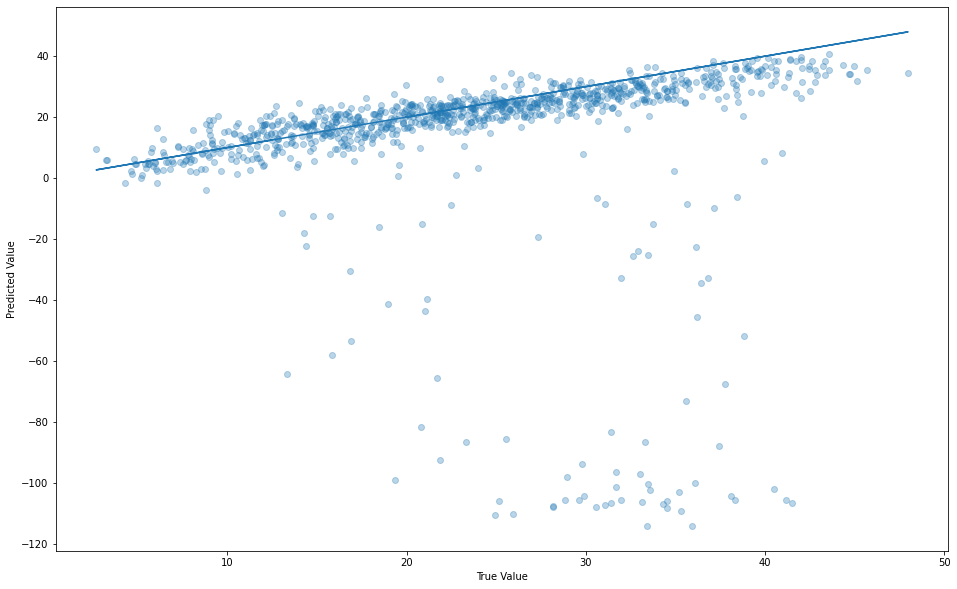

In [ ]:
# Plot predicted vs actual
plt.scatter(df[ycol][-1000:], lm.predict(df[in_cols][-1000:]), alpha=0.3)
plt.plot(df[ycol][-1000:], df[ycol][-1000:]) # A straight line - we want to be close to this
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

So the model is getting most predictions close to the mark, but some are waaaay off (causing the terrible score) and lots are negative! Let's move on to a better model.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
rf = RandomForestRegressor(n_estimators=100) # My go-to quick model for regression tasks.
rf.fit(df[in_cols][:-1000], df[ycol][:-1000])

RandomForestRegressor()

In [ ]:
rf.score(df[in_cols][-1000:], df[ycol][-1000:]) # Very good!

0.8122777830225314

In [ ]:
print("RMSE:", sqrt(mean_squared_error(df[ycol][-1000:], rf.predict(df[in_cols][-1000:]))))

RMSE: 4.13521158953426


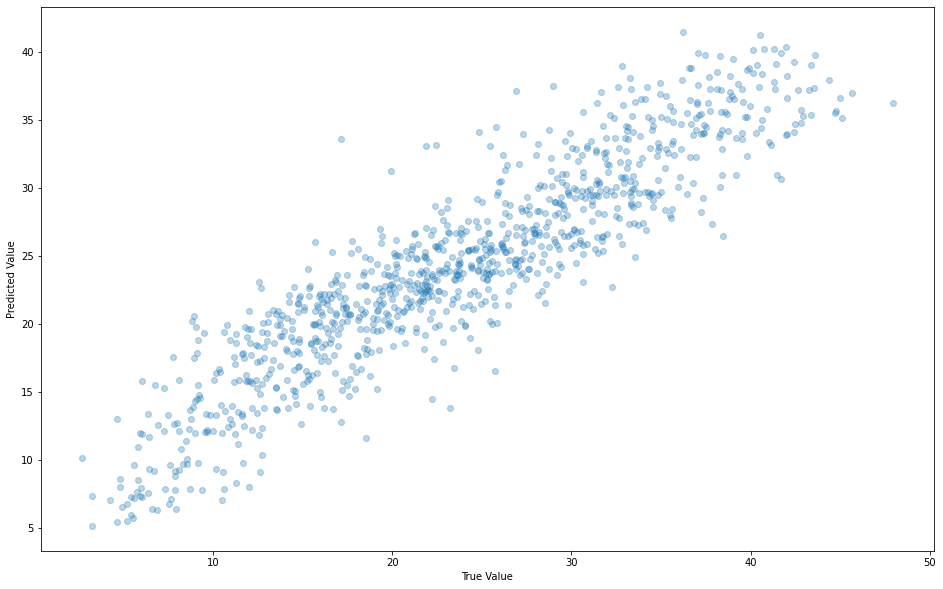

In [ ]:
plt.scatter(df[ycol][-1000:], rf.predict(df[in_cols][-1000:]), alpha=0.3)
plt.xlabel('True Value')
plt.ylabel('Predicted Value')
plt.savefig('pred_vs_actual_quick_rf_sequential_split.png')

Much better! We can see that the predicted values now line up fairly closely with the true values. 

A nice side-effect of this Random Forest model: We can see what features are most important to the model:

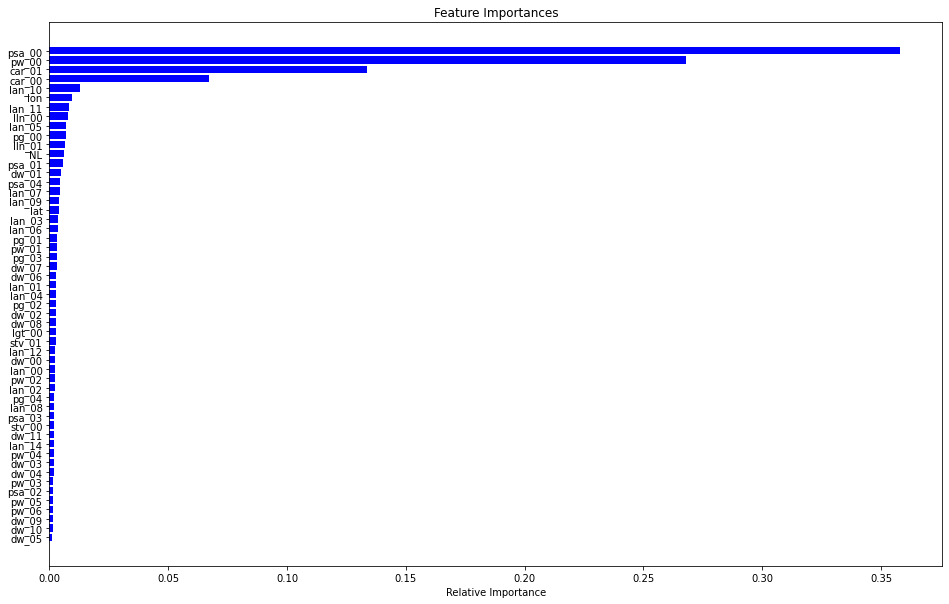

In [ ]:
features = in_cols
importances = rf.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<AxesSubplot:xlabel='psa_00', ylabel='target'>

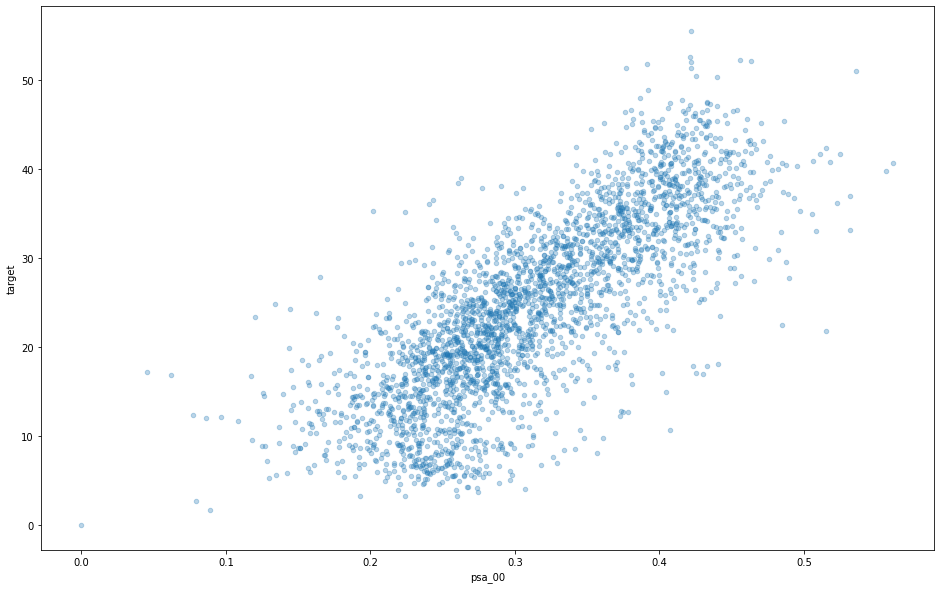

In [ ]:
# It turns out school attendance is VERY informative!
df.plot(x='psa_00', y='target', kind='scatter', alpha=0.3)

### Better scoring with Cross-Validation

We could start tweaking model parameters and trying different models, using the code above to get the score. But this gives a score for just one split - we could pick a worse model that just happens to do well on the last 1000 rows. instead, we'll use something called k-fold cross validation to get a better estimate of how well one model does in relation to another.

In [ ]:
from sklearn.model_selection import KFold

# Demonstrating splits
kf = KFold(n_splits=5, shuffle=False)
for train, test in kf.split(df):
  print(df.iloc[train].shape, df.iloc[test].shape)

(2257, 58) (565, 58)
(2257, 58) (565, 58)
(2258, 58) (564, 58)
(2258, 58) (564, 58)
(2258, 58) (564, 58)


In [ ]:
# Using this to test a model on 5 different splits
kf = KFold(n_splits=5, shuffle=False)

scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
  print(rmse)

print("Average score in 5-fold CV:", np.mean(scores))

3.8591205150827395
3.4809810729859927
4.586228205769989
4.25888318261286
3.9946827606236988
Average score in 5-fold CV: 4.035979147415056


As you can see, the scores vary depending on the split. Taking the average of 5 runs gives a much better estimate of the total. You could go higher, but 5 should be enough to see major differences.

A question for you: Why did we set shuffle=False?

In [ ]:
kf = KFold(n_splits=5, shuffle=True)
scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
  print(rmse)

print("Average score in 5-fold CV:", np.mean(scores))

3.641869403727508
3.3808839008633247
3.5126784418449875
3.359426317113333
3.7848403865120828
Average score in 5-fold CV: 3.535939690012247


The wards are bits of land in South Africa. If we do a random split, we will have wards in the test set with adjacent wards in the training set. Since nearby locations are often similar, the model is able to make good guesses simply by looking at the neighbouring wards and extrapolating. But for this model to be useful, we want it to generalise well, so that we could potentially make predictions for now without doing ANY surveys. 

This is reflected in the way Zindi split the data - certain provinces are not represented at all in the training set. By splitting sequentially, we take advantage of the way the training set is ordered (by ward code) to do our own 'geographical' splits where adjacent regions are grouped together. 

So, use `shuffle=False` to get a better idea of what your model will score on Zindi.

### Tip: Sometimes a quick test/train split is enough to get an idea about how well something is doing, but when you're tuning parameters and comparing models it's worth the extra effort to do things rigorously. Try creating a score_model() function to make this quick and effortless going forward.

# Feature Engineering and Model Tuning

Let's add a new feature and tune our model a little bit, to see if we can beat our current score (4.01).

In [ ]:
# Average household size - might contain some useful information
df['Household_Size'] = df['total_individuals']/df['total_households']

In [ ]:
in_cols = df.drop('ADM4_PCODE', axis=1).columns[4:]
in_cols # Check that the new feature is included

Index(['dw_00', 'dw_01', 'dw_02', 'dw_03', 'dw_04', 'dw_05', 'dw_06', 'dw_07',
       'dw_08', 'dw_09', 'dw_10', 'dw_11', 'psa_00', 'psa_01', 'psa_02',
       'psa_03', 'psa_04', 'stv_00', 'stv_01', 'car_00', 'car_01', 'lln_00',
       'lln_01', 'lan_00', 'lan_01', 'lan_02', 'lan_03', 'lan_04', 'lan_05',
       'lan_06', 'lan_07', 'lan_08', 'lan_09', 'lan_10', 'lan_11', 'lan_12',
       'lan_14', 'pg_00', 'pg_01', 'pg_02', 'pg_03', 'pg_04', 'lgt_00',
       'pw_00', 'pw_01', 'pw_02', 'pw_03', 'pw_04', 'pw_05', 'pw_06', 'lat',
       'lon', 'NL', 'Household_Size'],
      dtype='object')

In [ ]:
# Test in CV
kf = KFold(n_splits=5, shuffle=False)
scores = []
for train, test in kf.split(df):
  rf = RandomForestRegressor(n_estimators=100)
  rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
  rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
  scores.append(rmse)
print("Average score in 5-fold CV:", np.mean(scores))

Average score in 5-fold CV: 4.009982733541283


A small improvement, but every little bit helps!

### Tip: Spend some time on feature engineering. Look at ways to combine columns, or redundant info (percentage WITH car = 100- percentage without car, so perhaps one could be scrapped?). Check out extra sources of info. Can you use the coorinates to classify wards as Urban vs Rural? How about using the ward code to find the wards in the shapefile, and getting geographical area or coastline? For the very advanced, even satellite imagery might yield some useful info...

Let's try to tune the max_depth parameter in case our model is overfitting.

In [ ]:
for md in [3, 4, 5, 7, 9, 12, 15]:
  scores = []
  for train, test in kf.split(df):
    rf = RandomForestRegressor(n_estimators=100, max_depth=md)
    rf.fit(df[in_cols].iloc[train], df[ycol].iloc[train])
    rmse = sqrt(mean_squared_error(df[ycol].iloc[test], rf.predict(df[in_cols].iloc[test])))
    scores.append(rmse)
  print("Average score in 5-fold CV:", np.mean(scores), "for max depth:", md)

Average score in 5-fold CV: 4.8087981535931466 for max depth: 3
Average score in 5-fold CV: 4.5054298044729695 for max depth: 4
Average score in 5-fold CV: 4.300400179784929 for max depth: 5
Average score in 5-fold CV: 4.111049942837624 for max depth: 7
Average score in 5-fold CV: 4.010871695735586 for max depth: 9
Average score in 5-fold CV: 3.988830105978729 for max depth: 12
Average score in 5-fold CV: 3.9716559726637586 for max depth: 15


Deeper models did better. 
### Tip: Try plotting score vs depth, and see where the model stops improving. You can also tune many other parameters

### Tip: Experiment with different models! There are many to choose from, and my favourite old Random Forest is feeling a little overwhelmed by the cool kids: XGBoost, LGBMs, NODE, 🐱boost...

# Making a submission

OK, so we have a model we're happy with. Now to make our submission. First, let's look at the submission format

In [ ]:
pd.read_csv('SampleSubmission.csv').head()

FileNotFoundError: [Errno 2] No such file or directory: 'SampleSubmission.csv'

For each ward, we need to predict the target. Let's do it

In [ ]:
# Load the test data
test = pd.read_csv('Test.csv')
# Add any extra features just as we did for train
test['Household_Size'] = test['total_individuals']/test['total_households']

In [ ]:
# Fit a model on the whole training set, using our best parameters
rf = RandomForestRegressor(n_estimators=100, max_depth=15)
rf.fit(df[in_cols], df[ycol])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [ ]:
# Make predictions
test['target'] = rf.predict(test[in_cols])
test.head()

ward  total_households  ...  Household_Size     target
0  21001001: Ward 1        2504.95194  ...        3.491145  18.878350
1  21001002: Ward 2        2080.27718  ...        3.489015  14.529233
2  21001003: Ward 3        1106.62639  ...        5.348808  21.566158
3  21001004: Ward 4        2175.56096  ...        4.725482  15.015727
4  21001005: Ward 5        1270.83883  ...        4.735724  21.150553

[5 rows x 64 columns]

In [ ]:
# Save and submit!
test[['ward', 'target']].to_csv('starter_nb_submission.csv', index=False)

And that's it! Upload your submission file to Zindi and see what you get :) If all works out well, you should get a score very similar to the one we got in our tests. That said, the test set includes Cape Town, so if your score is slightly lower than expected feel free to blame it on the DA ;)